# Flux computation

In [1]:
import pyvista
import lfricflux
import mint
import vtk
import numpy as np

In [2]:
# the LFRic diagnostic file containing W2h data
inputFile = '../data/gungho/original/lfric_diag.nc'
# configuration file that lists the variables of interest
configFile = '../configs/lfric.cfg'

In [3]:
# compute the flux across an irregular line.
# The points are connected by straight lines in lon-lat space. To close the line, 
# let the last point be the same as the first.
# Here, we compute the flux across 'nsegs' segments -- the points are one a circle in 
# lon-lat. 
nsegs = 5
# instantiate flux calculators
lfs = [lfricflux.LFRicFlux(configFile=configFile, inputFile=inputFile) for i in range(nsegs)]
fluxes = [None for i in range(nsegs)]
dangle = 2 * np.pi / nsegs
xc, yc = 40, 30 # centre of the circle
radius = 35
nsubsegs = 2 # number of sub-segments
dt = dangle / nsubsegs
for i in range(nsegs):
    anglebeg = i*dangle
    xy = [(xc + radius*np.cos(anglebeg + j*dt), 
           yc + radius*np.sin(anglebeg + j*dt)) for j in range(nsubsegs + 1)]
    print(f'i={i} xy={xy}')
    # compute the flux for this segment
    fluxes[i] = lfs[i].computeFlow(xy)

i=0 xy=[(75.0, 30.0), (68.31559480312316, 50.572483830236564), (50.81559480312316, 63.28697807033037)]
i=1 xy=[(50.81559480312316, 63.28697807033037), (29.184405196876845, 63.28697807033038), (11.684405196876842, 50.572483830236564)]
i=2 xy=[(11.684405196876842, 50.572483830236564), (5.0, 30.000000000000004), (11.684405196876838, 9.427516169763443)]
i=3 xy=[(11.684405196876838, 9.427516169763443), (29.184405196876835, -3.2869780703303704), (50.815594803123155, -3.2869780703303775)]
i=4 xy=[(50.815594803123155, -3.2869780703303775), (68.31559480312316, 9.427516169763436), (75.0, 29.999999999999993)]


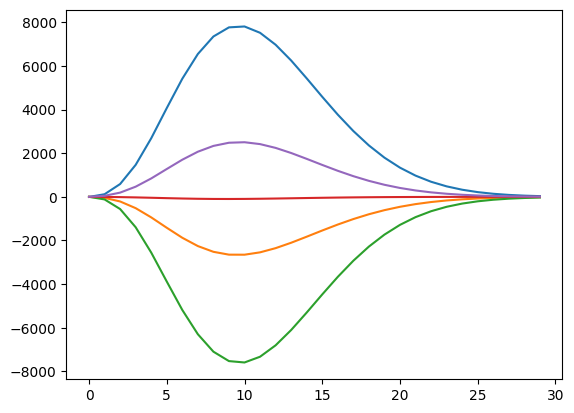

In [4]:
# plot the total flux for each level
import matplotlib.pylab as plt
ntimes, nelevs = lfs[0].getExtraDims()
levels = np.array(range(nelevs))
for i in range(nsegs):
    plt.plot(levels, fluxes[i][0, :])

In [5]:
# plot the vector field
x, y = lfs[0].getEdgeLonLat()
vf = lfricflux.VtkVectors(x, y, vector_field_name='flow', cartesian=False)
vf.setField(lfs[0].rho_u_dz, lfs[0].rho_v_dz)

In [6]:
def getUVMax(vf):
    vxyz = vf.getFieldArray()
    return np.amax(np.sqrt(np.sum(vxyz**2, axis=1)))

In [7]:
# set the time, elev, ...
time_elev = (0, 0)
vf.setSlice(time_elev)

In [8]:
# create a vector field visualisation using VTK. Pyvista can also do it but I found that it is not possible 
# to create a vector visulisation in pyvista without copying the data. Fortunately, pyvista's rendering 
# also works with VTK pipelines.

# want to attach arrows to each point
arrow = vtk.vtkArrowSource()

glyphs = vtk.vtkGlyph3D()
glyphs.SetScaleModeToScaleByVector()
glyphs.SetColorModeToColorByVector()

# scale the glyphs
uvMax = getUVMax(vf)
scale = 30 / uvMax
glyphs.SetScaleFactor(scale)
glyphs.SetRange(0., uvMax)

# connect. VTK works with meshes, which can have fields attached to them. In this case, 
# there is a single field - no need to tell VTK what to plot. 
glyphs.SetInputData(vf.getMesh())
glyphs.SetSourceConnection(arrow.GetOutputPort())

In [9]:
# build the target grid for vosualisation 
for i in range(nsegs):
    lfs[i].buildFluxSurface(extrusion=10, cartesian=False, radius=1.0)
    lfs[i].setSlice(time_elev)

In [10]:
# plot
pyvista.global_theme.cmap = 'jet'
p = pyvista.Plotter(window_size=(900, 800))
p.set_background((0.9, 0.9, 0.92))
for i in range(nsegs):
    p.add_mesh(lfs[i].targetGrid, scalars='flux') 
p.add_mesh(glyphs)
p.show()

Widget(value="<iframe src='http://localhost:61001/index.html?ui=P_0x17b39dd80_0&reconnect=auto' style='width: …

In [ ]:
for i in range(nsegs):
    print(f'flux = {lfs[i].flux[time_elev]}')

In [ ]:
for i in range(nsegs):
    for j in range( )